### Fine-tuning of a sentiment analysis classification model ###

In [43]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from pprint import pprint
import textwrap
from pathlib import Path
from pprint import pprint
from matplotlib import pyplot as plt

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# PyTorch
import torch
from torchinfo import summary

# Hugging Face 
from transformers import pipeline, set_seed, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

# This HuggingFace community-driven open-source library of datasets
from datasets import load_dataset, load_metric

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import transformermodels as tm
print(f'Package version: {tm.__version__}')
print(f'PyTorch version: {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: 0.0.post1.dev8+gd983d5a.d20240721
PyTorch version: 2.3.1+cu121


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce GTX 1080 with Max-Q Design
CUDNN version:         8902

Device for model training/inference: cuda:0


In [3]:
# Helper functions and parameters
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

# Directories
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'transformers')
model_dir = os.path.join(data_dir, 'model_trained')
Path(model_dir).mkdir(parents=True, exist_ok=True)
# Load the HuggingFace datasets
# Full list of datasets
# https://huggingface.co/datasets
# dataset = load_dataset('amazon_polarity')

# The custom data set
#!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
data_file_name = 'AirlineTweets.csv'
data_file = os.path.join(data_dir, data_file_name)
df_ = pd.read_csv(data_file)
display(df_.head(2))

# We only need the text and the labels
df = df_[['text', 'airline_sentiment']]
display(df.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


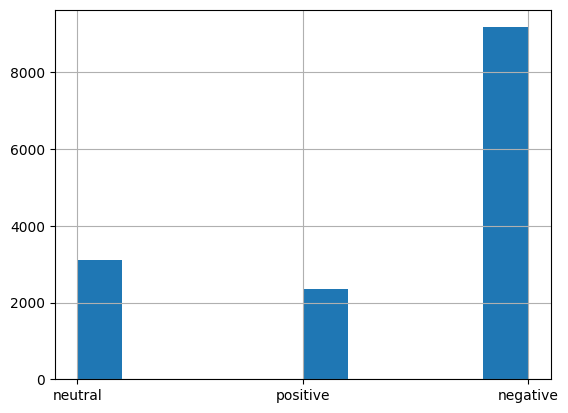

In [4]:
df['airline_sentiment'].hist()
plt.show()
# This is a highly imbalanced data set

In [5]:
# Map the labelsto integers
print(list(df['airline_sentiment'].unique()))
# Hard-code the label mapping
label_names = ['negative', 'positive', 'neutral']
label_targets = [0, 1, 2]
label_dict = dict(zip(label_names, label_targets))
pprint(label_dict)

# This is cool: we do not use apply here. Just mappings.
df = df_[['text', 'airline_sentiment']].assign(target=df_['airline_sentiment'].map(label_dict))
display(df.head())

['neutral', 'positive', 'negative']
{'negative': 0, 'neutral': 2, 'positive': 1}


,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


In [6]:
# Create a simplified df
df2 = df[['text', 'target']]

# To use the "load_dataset" function, we need to have specific column names
df2.columns = ['sentence', 'label']
display(df2.head())

df2_name = f'{os.path.splitext(data_file_name)[0]}.parquet'
df2_file = os.path.join(data_dir, df2_name)
print(df2_file)
df2.to_parquet(df2_file)

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


/home/andreas/data/transformers/AirlineTweets.parquet


In [7]:
# Load the .parquet file as a HuggingFace dataset
raw_dataset = load_dataset('parquet', data_files=df2_file)
split = raw_dataset.get('train').train_test_split(test_size=0.3, seed=42)

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
display(split)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [9]:
# DEFINE MODEL CHECKPOINT
checkpoint = 'distilbert-base-cased'

# DEFINE THE MODEL
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=checkpoint, num_labels=3)

# CREATE TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_fn(batch):
    ''' We need to handle truncation here. Padding will be handled by the Trainer class '''
    return tokenizer(batch.get('sentence'), truncation=True)

# TOKENIZE THE DATA SETS
tokenized_datasets = split.map(tokenize_fn, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [10]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [11]:
# METRICS FUNCTION
def compute_metrics(logits_and_labels):
    """ We need this for the trainer to compute the evaluation metrics """
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    output_dict = {'acc': acc, 'f1': f1}
    return output_dict

In [12]:
# TRAINING ARGUMENTS
output_dir = os.path.join(model_dir, 'custom_sentiment')
Path(output_dir).mkdir(exist_ok=True, parents=True)
training_args = TrainingArguments(output_dir=output_dir,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  logging_steps=50,
                                  per_device_train_batch_size=96,
                                  per_device_eval_batch_size=96)

In [13]:
# TRAINER CLASS
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_datasets.get('train'),
                  eval_dataset=tokenized_datasets.get('test'),
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [14]:
# trainer.train()
# Save the model
# trainer.save_model(output_dir)

In [15]:
# Load the model from the training checkpoint
custom_checkpoint = os.path.join(output_dir, 'checkpoint-214')
print(custom_checkpoint)

/home/andreas/data/transformers/model_trained/custom_sentiment/checkpoint-214


In [16]:
savedmodel = pipeline(task='text-classification', model=custom_checkpoint, device=device)

In [25]:
print(savedmodel('This airline sucks.'))
print(label_dict)
# Get the inverse
label_dict_inv = {val: key for key, val in label_dict.items()}
print(label_dict_inv)

{'negative': 0, 'positive': 1, 'neutral': 2}
{0: 'negative', 1: 'positive', 2: 'neutral'}


In [26]:
# Replace the labels in the config file
config_file = os.path.join(custom_checkpoint, 'config.json')

# Open the config file
with open(config_file) as fl:
    js = json.load(fl)

# Add the labels mappings
js.update({'id2label': label_dict_inv})

# Save the new configuration file
with open(config_file, 'w') as fl:
    json.dump(js, fl, indent=2)

display(js)

{'_name_or_path': 'distilbert-base-cased',
 'activation': 'gelu',
 'architectures': ['DistilBertForSequenceClassification'],
 'attention_dropout': 0.1,
 'dim': 768,
 'dropout': 0.1,
 'hidden_dim': 3072,
 'id2label': {0: 'negative', 1: 'positive', 2: 'neutral'},
 'initializer_range': 0.02,
 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2},
 'max_position_embeddings': 512,
 'model_type': 'distilbert',
 'n_heads': 12,
 'n_layers': 6,
 'output_past': True,
 'pad_token_id': 0,
 'problem_type': 'single_label_classification',
 'qa_dropout': 0.1,
 'seq_classif_dropout': 0.2,
 'sinusoidal_pos_embds': False,
 'tie_weights_': True,
 'torch_dtype': 'float32',
 'transformers_version': '4.42.4',
 'vocab_size': 28996}

In [29]:
savedmodel = pipeline(task='text-classification', model=custom_checkpoint, device=device)
print(savedmodel('This airline sucks.'))
print(savedmodel('This burger is super good.'))

[{'label': 'negative', 'score': 0.9989983439445496}]
[{'label': 'positive', 'score': 0.9934822916984558}]


In [34]:
# Plot the confusion matrix for another checkpoint
custom_checkpoint = os.path.join(output_dir, 'checkpoint-321')
savedmodel = pipeline(task='text-classification', model=custom_checkpoint, device=device)
test_pred = savedmodel(split['test']['sentence'])

def get_label(d):
  return int(d['label'].split('_')[1])

test_pred_labels = [get_label(d) for d in test_pred]

In [40]:
pprint(test_pred[:3])
pprint(test_pred_labels[:3])
print()
print("acc:", accuracy_score(split['test']['label'], test_pred_labels))
print("f1:", f1_score(split['test']['label'], test_pred_labels, average='macro'))

[{'label': 'LABEL_1', 'score': 0.9606209397315979},
 {'label': 'LABEL_1', 'score': 0.9876927733421326},
 {'label': 'LABEL_2', 'score': 0.649779736995697}]
[1, 1, 2]

acc: 0.8262750455373407
f1: 0.7695995838579882


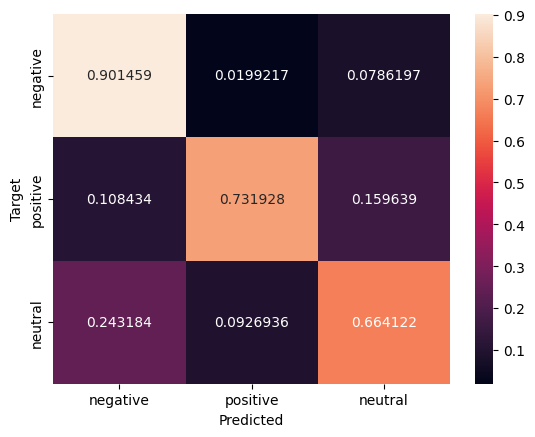

In [45]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred_labels, normalize='true')
plot_cm(cm)